---
date: last-modified
---

# MOPITT Carbon Monoxide (CO) Mixing Ratio

## Summary

This code makes a GIF from the `RetrievedCOMixingRatioProfileDay` variable from Measurements Of Pollution In The Troposphere (MOPITT).

## Prerequisites

A free(!) account at https://www.earthdata.nasa.gov/ is needed to login and download the appropriate files.

This notebook was tested last using Python 3.10.15, and requires these libraries:

- [cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/)
- [h5py](https://docs.h5py.org/en/stable/index.html)
- [matplotlib](http://matplotlib.org/)
- [numpy](https://numpy.org/)
- [PIL](https://pypi.org/project/pillow/)

### Notebook Author / Affiliation

By Cheyenne Land / Atmospheric Science Data Center

## 1. Setup

In [1]:
import os
from pathlib import Path

import cartopy.crs as ccrs
import earthaccess
import h5py
import numpy as np
import PIL
from matplotlib import pyplot as plt

## 2. Search for data using earthaccess

We use `earthaccess` to streamline the login to NASA Earthdata. 

<details open>
  <summary><i>Additional resources about earthaccess</i></summary>

- [*earthaccess* documentation](https://earthaccess.readthedocs.io/en/latest/)
- [Earthdata Cloud Cookbook](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/tutorials/earthaccess-demo.html)
</details>

In [2]:
earthaccess.login()

In [3]:
short_name = "MOP03JM"
version = "9"

results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    provider="LARC_CLOUD",  # this is needed only temporary, while there are still non-LARC_CLOUD versions of these granules.
    temporal=("2024-09", "2024-10"),
)

print(f"{len(results)} file(s) found.")

2 file(s) found.


In [4]:
print(results)

[Collection: {'ShortName': 'MOP03JM', 'Version': '9'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-09-01T00:00:04.694Z', 'EndingDateTime': '2024-09-01T23:59:59.999Z'}}
Size(MB): 146.863
Data: ['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/MOPITT/MOP03JM.9/2024.09.01/MOP03JM-202409-L3V95.10.3.he5'], Collection: {'ShortName': 'MOP03JM', 'Version': '9'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-10-01T00:00:05.832Z', 'EndingDateTime': '2024-10-01T23:59:59.999Z'}}
Size(MB): 149.263
Data: ['https://dat

## 3. Download data

In [5]:
downloaded_files = earthaccess.download(results, local_path=".")
downloaded_files

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

['MOP03JM-202409-L3V95.10.3.he5', 'MOP03JM-202410-L3V95.10.3.he5']

## 4. Open the files

In [6]:
arrays = {"lon": [], "lat": [], "CO_mixing_ratio": []}

# Open and read file
for i, file in enumerate(downloaded_files):
    with h5py.File(file, mode="r") as f:
        # Slice data to get the pressure level of your choice
        #   [Longitude(Xdim):360 , Latitude(Ydim):180, Presure level:9]
        #   Pressure Level: 0 = 900 hPa, 1 = 800 hPa, 2 = 700 hPa, 3 = 600 hPa
        #   4 = 500 hPa, 5 = 400 hpa, 6 = 300 hPa, 7 = 200 hPa, 8 = 100 hPa
        data = f["/HDFEOS/GRIDS/MOP03/Data Fields/RetrievedCOMixingRatioProfileDay"][:]
        data = np.transpose(data)

        # Retrieve the lat and lon data as well as the area of your choice
        lon = f["/HDFEOS/GRIDS/MOP03/Data Fields/Longitude"][:]
        lat = f["/HDFEOS/GRIDS/MOP03/Data Fields/Latitude"][:]

        # Turn the -9999.0 into a NaN
        masked_data = np.ma.masked_where(data <= 0, data)
        CO_mixing_ratio = data.copy()
        CO_mixing_ratio[masked_data <= 0] = np.nan

        arrays["lon"].append(lon)
        arrays["lat"].append(lat)
        arrays["CO_mixing_ratio"].append(CO_mixing_ratio)

## 5. Generate plots

In [7]:
pressure_levels = np.arange(0, 9)

proj = ccrs.PlateCarree()

for file_index, file in enumerate(downloaded_files):
    filestem = Path(file).stem
    os.makedirs(filestem, exist_ok=True)

    # Plot all graphs.
    for i in pressure_levels:
        fig, ax = plt.subplots(figsize=(7.20, 3.60), dpi=80, subplot_kw={"projection": proj})

        im = ax.contourf(
            arrays["lon"][file_index],
            arrays["lat"][file_index],
            arrays["CO_mixing_ratio"][file_index][i, :, :],
            levels=np.linspace(0, 430, 25),
            cmap="jet",
            vmin=0,
            vmax=430,
            transform=proj,
        )
        ax.coastlines()

        cb = plt.colorbar(im, shrink=0.76)
        cb.set_label("ppbv", fontsize=8)

        pressure_prefix = -i + 9
        plt.title(
            f"{file}\n RetrievedCOMixingRatioProfileDay_{str(pressure_prefix)}00hPa", fontsize=8
        )

        # Save the figure.
        name_prefix = f"{filestem}/{filestem}_RetrievedCOMixingRatioProfileDay"
        plt.savefig(f"{name_prefix}_{pressure_prefix}00hPa.jpg", dpi=400)
        print(f"Plot has been saved: {name_prefix}_{pressure_prefix}00hPa.jpg")
        plt.close()

Plot has been saved: MOP03JM-202409-L3V95.10.3/MOP03JM-202409-L3V95.10.3_RetrievedCOMixingRatioProfileDay_900hPa.jpg
Plot has been saved: MOP03JM-202409-L3V95.10.3/MOP03JM-202409-L3V95.10.3_RetrievedCOMixingRatioProfileDay_800hPa.jpg
Plot has been saved: MOP03JM-202409-L3V95.10.3/MOP03JM-202409-L3V95.10.3_RetrievedCOMixingRatioProfileDay_700hPa.jpg
Plot has been saved: MOP03JM-202409-L3V95.10.3/MOP03JM-202409-L3V95.10.3_RetrievedCOMixingRatioProfileDay_600hPa.jpg
Plot has been saved: MOP03JM-202409-L3V95.10.3/MOP03JM-202409-L3V95.10.3_RetrievedCOMixingRatioProfileDay_500hPa.jpg
Plot has been saved: MOP03JM-202409-L3V95.10.3/MOP03JM-202409-L3V95.10.3_RetrievedCOMixingRatioProfileDay_400hPa.jpg
Plot has been saved: MOP03JM-202409-L3V95.10.3/MOP03JM-202409-L3V95.10.3_RetrievedCOMixingRatioProfileDay_300hPa.jpg
Plot has been saved: MOP03JM-202409-L3V95.10.3/MOP03JM-202409-L3V95.10.3_RetrievedCOMixingRatioProfileDay_200hPa.jpg
Plot has been saved: MOP03JM-202409-L3V95.10.3/MOP03JM-202409-L3

## 6. Create gif

In [8]:
frames = []
pressures = np.arange(1, 10)[::-1]

for file in downloaded_files:
    filestem = Path(file).stem
    name_prefix = f"{filestem}/{filestem}_RetrievedCOMixingRatioProfileDay"

    for j in pressures:
        new_frame = PIL.Image.open(rf"{name_prefix}_{j}00hPa.jpg")
        frames.append(new_frame)
        frames[0].save(
            f"{name_prefix}_PressureLevels.gif",
            format="GIF",
            append_images=frames[:],
            save_all=True,
            duration=250,
            loop=0,
            quality=75,
            optimize=True,
        )

    print(f"GIF has been saved: {name_prefix}_PressureLevels.gif")

GIF has been saved: MOP03JM-202409-L3V95.10.3/MOP03JM-202409-L3V95.10.3_RetrievedCOMixingRatioProfileDay_PressureLevels.gif
GIF has been saved: MOP03JM-202410-L3V95.10.3/MOP03JM-202410-L3V95.10.3_RetrievedCOMixingRatioProfileDay_PressureLevels.gif


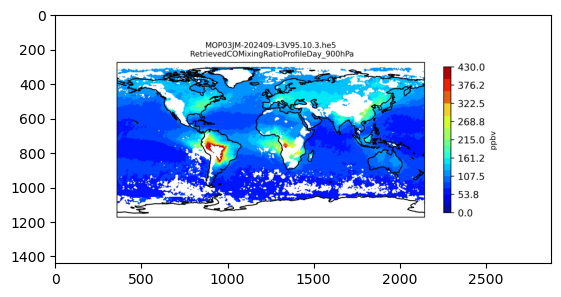

In [9]:
# Display first frame of gif in notebook for illustration purposes.
import matplotlib.image as mpimg

img = mpimg.imread(f"{name_prefix}_PressureLevels.gif")
plt.imshow(img)